In [ ]:
from math import sqrt 
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import time
import json

from matplotlib import pyplot
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, r2_score, mean_squared_error, accuracy_score
from keras.models import Sequential, model_from_json
from keras.layers import Dense, LSTM, Dropout
from keras import backend as K

%matplotlib inline

#Funciones

In [ ]:
def helada(row):
  if row['Y'] <= 0:
    return 0
  else: 
    return 1 

In [ ]:
def plot_historylr(histo, epochs):
  hist = pd.DataFrame(histo.history)
  hist['epoch'] = range(epochs)

  pyplot.figure(figsize=(5, 5))
  plt.xlabel('Épocas')
  plt.ylabel('MSE')
  plt.plot(hist['epoch'], hist['loss'],  label='Entrenamiento')
  plt.plot(hist['epoch'], hist['val_loss'], label = 'Validación')
  plt.legend()
  plt.show()

#Parámetros

In [ ]:
look_back=18
col=['LowTemp']
colnames= []

In [ ]:
def coeff_determination(y_true, y_pred):
  SS_res =  K.sum(K.square( y_true-y_pred )) 
  SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
  return ( 1 - SS_res/(SS_tot + K.epsilon()) )

#Preprocesamiento

In [ ]:
for i in range(look_back): 
  for s in col:
    colnames.append(s+str(i+1))

cantCaract= len(colnames)

colnames.append("Y")
colnames.append("DateTime")

In [ ]:
df_inta = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datos/datosINTA_TempHumRocioVientoRadBarHora_conVentana3hs_3hshorizonte.csv', usecols=colnames,low_memory=False)
df_inta['DateTime'] = pd.to_datetime(df_inta['DateTime'], format='%Y-%m-%d %H:%M:%S')
df_inta= df_inta.sort_values(by='DateTime')

In [ ]:
df_sf = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datos/datosSF_TempHumRocioVientoRadBarHora_conVentana3hs_3hshorizonte.csv', usecols=colnames,low_memory=False)
df_sf['DateTime'] = pd.to_datetime(df_sf['DateTime'], format='%Y-%m-%d %H:%M:%S')
df_sf= df_sf.sort_values(by='DateTime')

In [ ]:
col_num= colnames[:cantCaract+1]
for c in col_num:
  df_inta[c].mask(df_inta[c] == '---',0,inplace=True)
  df_inta[c]= pd.to_numeric(df_inta[c])
  df_sf[c].mask(df_sf[c] == '---',0,inplace=True)
  df_sf[c]= pd.to_numeric(df_sf[c])

#**Conjunto de entrenamiento y de test**

In [ ]:
df_sftrain= df_sf[df_sf.DateTime.dt.year <= 2017]
df_sfval= df_sf[df_sf.DateTime.dt.year > 2017]
df_test= df_inta

print('total de reg: {} 70% del total {} 30% del total {}'.format(len(df_sf),len(df_sf)*0.7,len(df_sf)*0.3))
print('total train {} total val {}'.format(len(df_sftrain),len(df_sfval)))
print(' porcentaje que representa los datos para train respecto del total SF: {}'.format(len(df_sftrain) *100/ len(df_sf)))

total de reg: 61011 70% del total 42707.7 30% del total 18303.3
total train 44203 total val 16808
 porcentaje que representa los datos para train respecto del total SF: 72.4508695153333


In [ ]:
xtrain= df_sftrain.iloc[:,0:cantCaract]
ytrain= df_sftrain.loc[:,'Y']
xval= df_sfval.iloc[:,0:cantCaract]
yval= df_sfval.loc[:,'Y']
xtest= df_test.iloc[:,0:cantCaract]
ytest= df_test.loc[:,'Y']

#** estandariza features**

In [ ]:
scalerX = StandardScaler()
scalerY = StandardScaler()

dataX= pd.concat([xtrain, xval, xtest], axis=0)
dataY= pd.concat([ytrain, yval, ytest], axis=0)

dataX= dataX.to_numpy()
print('----------X---------')
print(scalerX.fit(dataX.astype('float32')))
print('-------------------')
print(scalerX.mean_)
print(len(scalerX.mean_))

dataY= dataY.to_numpy().reshape(-1,1)
print('----------Y---------')
print(scalerY.fit(dataY.astype('float32')))
print('-------------------')
print(scalerY.mean_)

----------X---------
StandardScaler()
-------------------
[8.05173821 7.83913564 7.62931206 7.42457462 7.22743026 7.04004362
 6.86409678 6.70045129 6.548929   6.40897284 6.27932501 6.15857877
 6.04538996 5.93831296 5.83617205 5.73800203 5.64316916 5.55090689]
18
----------Y---------
StandardScaler()
-------------------
[4.42810071]


In [ ]:
trainX_scaler= scalerX.transform(xtrain.to_numpy())
trainY_scaler= scalerY.transform(ytrain.to_numpy().reshape(-1,1))
validationX_scaler= scalerX.transform(xval.to_numpy())
validationY_scaler= scalerY.transform(yval.to_numpy().reshape(-1,1))
testX_scaler= scalerX.transform(xtest.to_numpy())
testY_scaler= scalerY.transform(ytest.to_numpy().reshape(-1,1))

In [ ]:
print(testX_scaler.shape)
print(testY_scaler.shape)

(31613, 18)
(31613, 1)


In [ ]:
# # el reshape es necesario para hacer el fit_transform de la nomralizacion
# trainY = np.asarray(ytrain).reshape(-1,1)
# validationY = np.asarray(yval).reshape(-1,1)
# testY = np.asarray(ytest).reshape(-1,1)

In [ ]:
trainX_scaler = np.reshape(trainX_scaler, (trainX_scaler.shape[0], look_back, len(col)))
validationX_scaler = np.reshape(validationX_scaler, (validationX_scaler.shape[0], look_back, len(col)))
testX_scaler = np.reshape(testX_scaler, (testX_scaler.shape[0], look_back, len(col)))

#Entrenamiento

In [ ]:
#import keras.optimizers.Adam
import tensorflow as tf

def modelo(n_time_step, n_features, neuron, lr):
  model = Sequential()
  model.add(LSTM(neuron, activation= "relu",input_shape=(n_time_step, n_features)))  
  model.add(Dense(1))
  model.compile(loss='mse',optimizer= tf.keras.optimizers.Adam(learning_rate=lr), metrics=['mse'])  
  model.summary()
  return model

In [ ]:
neurons=[18]
num_epochs = [70]
learning_rates = [1E-3, 1E-4, 1E-5, 1E-6, 1E-7]
cantidad_modelos= len(learning_rates)
models = []
histories=[]

# pruebas con [1E-3, 1E-4, 1E-5, 1E-6, 1E-7]


In [ ]:
for i in range(len(learning_rates)):
  model = modelo(look_back,len(col),neurons[0],learning_rates[i])
  start_time= time.time()
  history= model.fit(trainX_scaler, trainY_scaler,epochs = num_epochs[0], verbose=0, validation_data= (validationX_scaler, validationY_scaler))
  histories.append(pd.DataFrame(history.history))
  models.append(model)
  end_time= time.time()
  print('duracion del entrenamiento: ', end_time - start_time)
  model.reset_states() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 18)                1440      
                                                                 
 dense (Dense)               (None, 1)                 19        
                                                                 
Total params: 1,459
Trainable params: 1,459
Non-trainable params: 0
_________________________________________________________________
duracion del entrenamiento:  923.5513150691986
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 18)                1440      
                                                                 
 dense_1 (Dense)             (None, 1)                 19        
                                                   

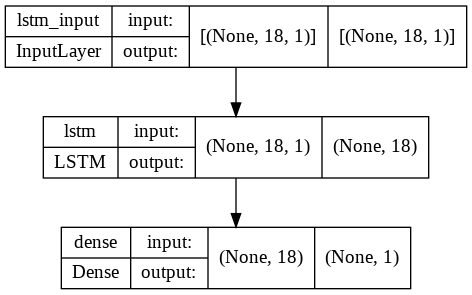

In [ ]:
tf.keras.utils.plot_model(models[0], show_shapes=True)

In [ ]:
learning_rates2 = [8E-7]

In [ ]:
num_epochs2= 85
for i in range(len(learning_rates2)):
  model = modelo(look_back,len(col),neurons[0],learning_rates2[i])
  start_time= time.time()
  history= model.fit(trainX_scaler, trainY_scaler,epochs = num_epochs2, verbose=0, validation_data= (validationX_scaler, validationY_scaler))
  histories.append(pd.DataFrame(history.history))
  models.append(model)
  end_time= time.time()
  print('duracion del entrenamiento: ', end_time - start_time)
  model.reset_states() 


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 18)                1440      
                                                                 
 dense (Dense)               (None, 1)                 19        
                                                                 
Total params: 1,459
Trainable params: 1,459
Non-trainable params: 0
_________________________________________________________________
duracion del entrenamiento:  776.9464433193207


In [ ]:
learning_rates += learning_rates2
print(learning_rates)
cantidad_modelos= len(learning_rates)

[0.001, 0.0001, 1e-05, 1e-06, 1e-07, 8e-07]


In [ ]:
print(sorted([0.001, 0.0001, 1e-05, 1e-06, 1e-07, 5e-07, 8e-07]))

[1e-07, 5e-07, 8e-07, 1e-06, 1e-05, 0.0001, 0.001]


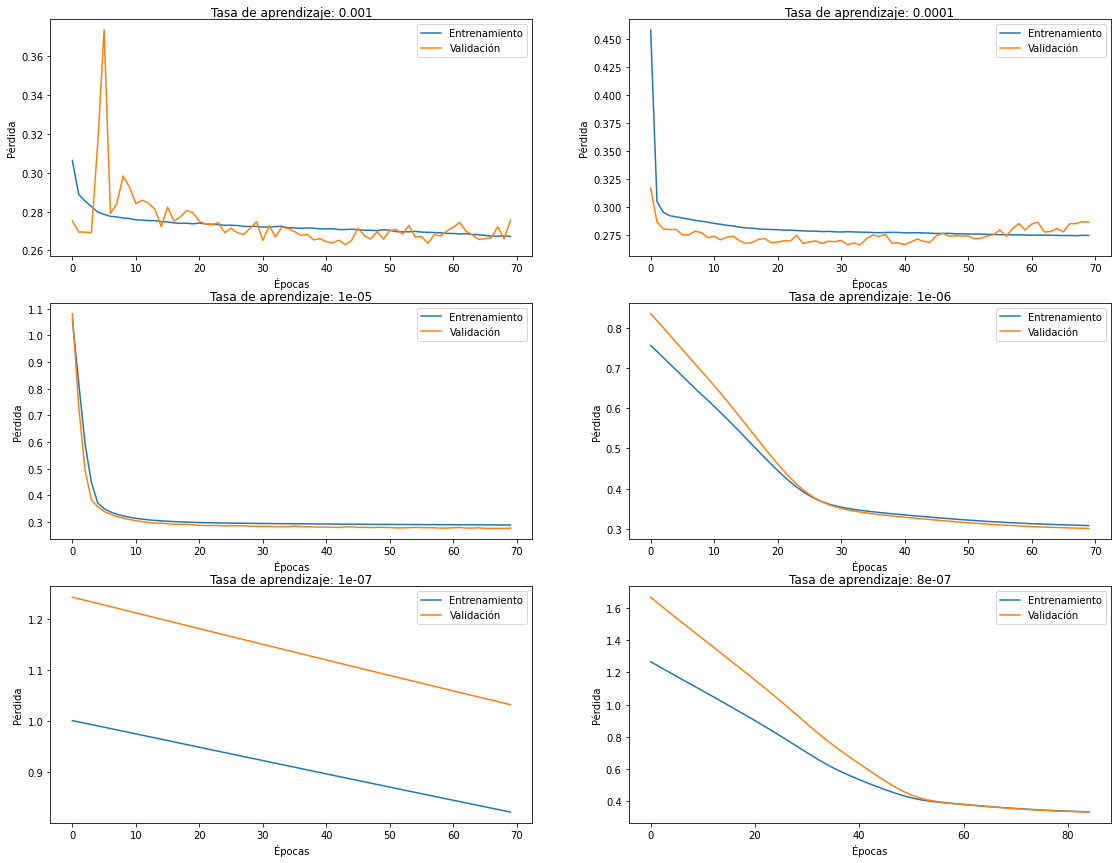

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [ ]:
pyplot.figure(figsize=(19, 20))
i=0
for h in histories:
  plot_no = 420 + (i+1)
  pyplot.subplot(plot_no)
  plt.plot(h['loss'], label='Entrenamiento')
  plt.plot(h['val_loss'], label='Validación')
  plt.title('Tasa de aprendizaje: '+str(learning_rates[i]), pad=-50)	
  plt.xlabel('Épocas')
  plt.ylabel('Pérdida')
  plt.legend()
  i+= 1
plt.show()
pyplot.figure(figsize=(5, 5))

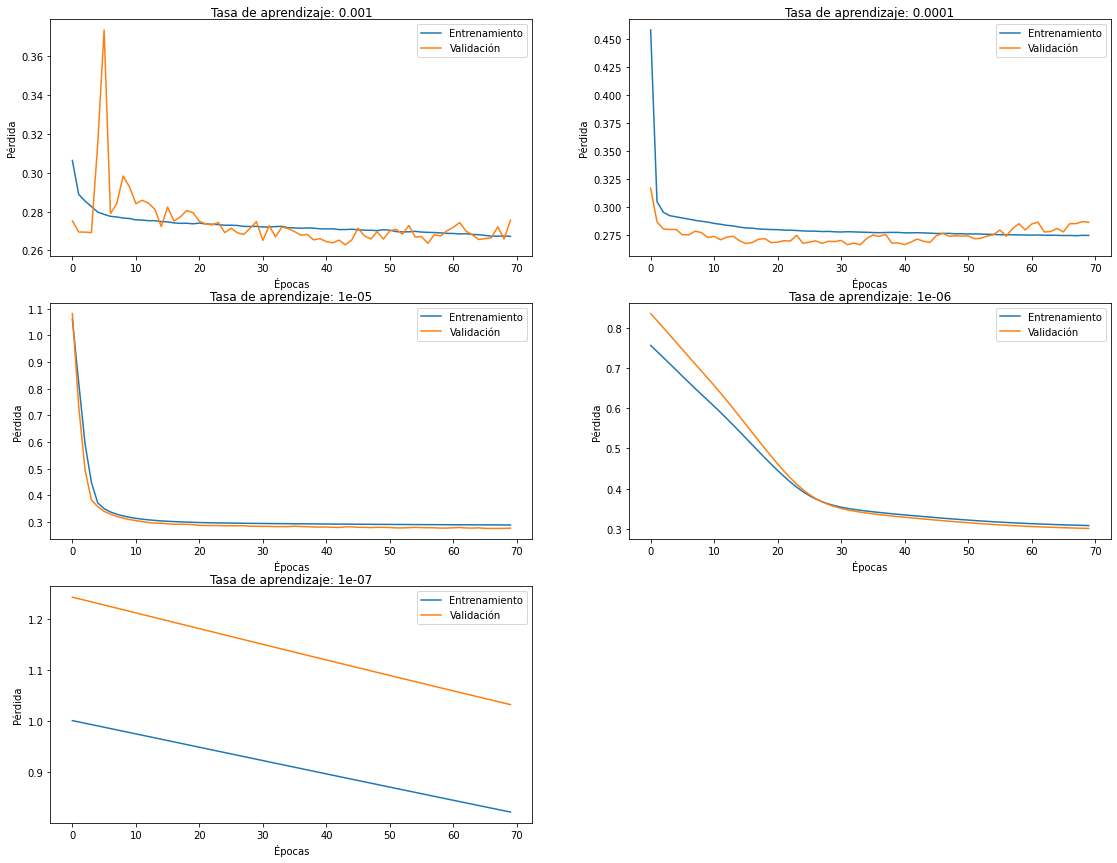

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [ ]:
pyplot.figure(figsize=(19, 20))
i=0
hist= histories[0:5]
for h in hist:
  plot_no = 420 + (i+1)
  pyplot.subplot(plot_no)
  plt.plot(h['loss'], label='Entrenamiento')
  plt.plot(h['val_loss'], label='Validación')
  plt.title('Tasa de aprendizaje: '+str(learning_rates[i]), pad=-50)	
  plt.xlabel('Épocas')
  plt.ylabel('Pérdida')
  plt.legend()
  i+= 1
plt.show()
pyplot.figure(figsize=(5, 5))

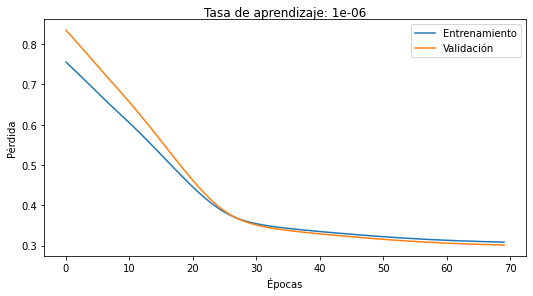

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [ ]:
pyplot.figure(figsize=(19, 20))
i=0
h= histories[3]
plot_no = 420 + (i+1)
pyplot.subplot(plot_no)
plt.plot(h['loss'], label='Entrenamiento')
plt.plot(h['val_loss'], label='Validación')
plt.title('Tasa de aprendizaje: '+str(learning_rates[3]), pad=-50)	
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()
plot_no = 420 + (i+1)
pyplot.figure(figsize=(5, 5))

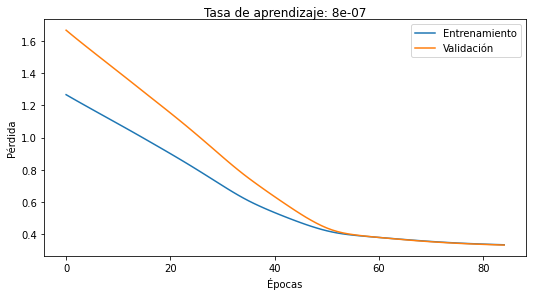

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [ ]:
pyplot.figure(figsize=(19, 20))
i=0
h= histories[5]
plot_no = 420 + (i+1)
pyplot.subplot(plot_no)
plt.plot(h['loss'], label='Entrenamiento')
plt.plot(h['val_loss'], label='Validación')
plt.title('Tasa de aprendizaje: '+str(learning_rates[5]), pad=-50)	
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()
plot_no = 420 + (i+1)
pyplot.figure(figsize=(5, 5))

In [ ]:
print("lr loss entrenamiento loss validacion")
i=0
for h in histories:  
  print("{:6} {:7.4f}      {:7.4f}".format(learning_rates[i],h["loss"].iloc[-1], h['val_loss'].iloc[-1]))
  i+=1

lr loss entrenamiento loss validacion
 0.001  0.2672       0.2755
0.0001  0.2750       0.2867
 1e-05  0.2894       0.2775
 1e-06  0.3088       0.3016
 1e-07  0.8217       1.0319
 8e-07  0.3333       0.3317


           0.001     0.0001      1e-05      1e-06      1e-07      8e-07
count  70.000000  70.000000  70.000000  70.000000  70.000000  70.000000
mean    0.272926   0.282280   0.323526   0.416694   0.910871   0.694562
std     0.005692   0.022005   0.116323   0.135182   0.052862   0.297230
min     0.267240   0.274760   0.289411   0.308806   0.821683   0.356076
25%     0.269716   0.276255   0.291272   0.320472   0.865976   0.408330
50%     0.271635   0.277788   0.294072   0.343860   0.910683   0.615326
75%     0.274044   0.280694   0.300847   0.488758   0.955696   0.951984
max     0.306251   0.457670   1.059728   0.755771   1.000595   1.267327


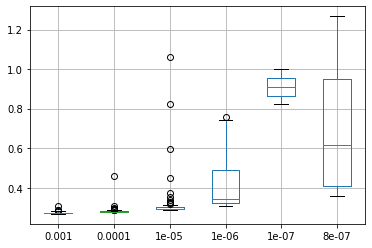

In [ ]:
results = pd.DataFrame()
i=0
for h in histories:
  results[str(learning_rates[i])]= h['loss']
  i+= 1
print(results.describe())
	
results.boxplot()

           1e-06      8e-07
count  70.000000  70.000000
mean    0.416694   0.694562
std     0.135182   0.297230
min     0.308806   0.356076
25%     0.320472   0.408330
50%     0.343860   0.615326
75%     0.488758   0.951984
max     0.755771   1.267327


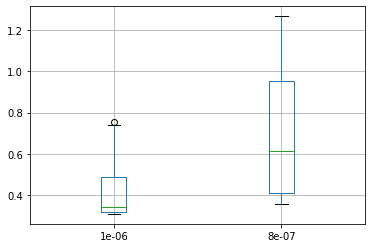

In [ ]:
results = pd.DataFrame()
h= histories[3]
results[str(learning_rates[3])] = h['loss']
h= histories[5]
results[str(learning_rates[5])] = h['loss']

print(results.describe())
	
results.boxplot()

In [ ]:
nombreModelo= "/content/drive/My Drive/Colab Notebooks/Datos2/LSTM_Univariada_Lr_StandardScaler_Modelo"

#-------- GUARDA LOS MODELOS --------

In [ ]:
# serializa el modelo para JSON
for i in range(cantidad_modelos):
  model_json = models[i].to_json()
  with open(nombreModelo+str(i)+".json", "w") as json_file:
    json_file.write(model_json)
  #serializan los pesos (weights) para HDF5
  models[i].save_weights(nombreModelo+str(i)+".h5")
  # guarda el history
  histories[i].to_csv(nombreModelo+'history_'+str(i)+'.csv',  index = False, header=True)  

print("Modelos guardado en el PC")
json_file.close()

Modelos guardado en el PC


# **Recuperar los modelos**

In [ ]:
# carga el json y crea el modelo
models=[]
histories=[]

for i in range(cantidad_modelos):
  json_file = open(nombreModelo+str(i)+".json", 'r')
  loaded_model_json = json_file.read()  
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  # se cargan los pesos (weights) en el nuevo modelo
  loaded_model.load_weights(nombreModelo+str(i)+".h5")
  models.append(loaded_model)
  # recupero el loss (mse) y el error (mae) de entrenamiento
  histories.append(pd.read_csv(nombreModelo+'history_'+str(i)+'.csv'))  

print("Modelos recuperados en el PC")

Modelos recuperados en el PC


#Evaluación y Predicción

In [ ]:
# make predictions
m_testPredict = []
m_testPredict_scaled = []

for i in range(cantidad_modelos):
  model_testPredict = models[i].predict(testX_scaler)
  model_testPredict = np.asarray(model_testPredict).reshape(-1,1)
  #guarda el y predicho normalizado
  m_testPredict_scaled.append(model_testPredict)
  #guarda el y predicho real
  model_testPredict = scalerY.inverse_transform(model_testPredict)
  m_testPredict.append(model_testPredict) 

In [ ]:
 #obtiene el error de cada modelo para el conjunto de datos de test
error_prediction=[]
error_prediction_scaled=[]
for i in range(cantidad_modelos):    
  error_prediction_scaled.append(testY_scaler.reshape(1,-1)[0] - m_testPredict_scaled[i][:,0])
  error_prediction.append(ytest.to_numpy().reshape(1,-1)[0] - m_testPredict[i][:,0])

In [ ]:
print('lr mse_train mse_val mse_test rmse_train mse_val mse_test r2_train r2_val r2_test')
for i in range(cantidad_modelos):
  trainpred= models[i].predict(trainX_scaler)  
  valpred= models[i].predict(validationX_scaler)  

  msetrain= mean_squared_error(ytrain.to_numpy().reshape(1,-1)[0], scalerY.inverse_transform(trainpred))  
  mseval =  mean_squared_error(yval.to_numpy().reshape(1,-1)[0], scalerY.inverse_transform(valpred))  
  msetest=  mean_squared_error(ytest.to_numpy().reshape(1,-1)[0], m_testPredict[i][:,0]) 

  rmsetrain= sqrt(mean_squared_error(ytrain.to_numpy().reshape(1,-1)[0], scalerY.inverse_transform(trainpred))  )
  rmseval=  sqrt(mean_squared_error(yval.to_numpy().reshape(1,-1)[0], scalerY.inverse_transform(valpred))) 
  rmsetest= sqrt(mean_squared_error(ytest.to_numpy().reshape(1,-1)[0], m_testPredict[i][:,0]))
  
  r2train= r2_score(ytrain.to_numpy().reshape(1,-1)[0], scalerY.inverse_transform(trainpred))
  r2val=   r2_score(yval.to_numpy().reshape(1,-1)[0], scalerY.inverse_transform(valpred))
  r2test= r2_score(ytest.to_numpy().reshape(1,-1)[0], m_testPredict[i][:,0])

  print('{:8}{:8.3f} {:8.3f} {:8.3f} {:8.3f} {:8.3f} {:8.3f} {:8.3f} {:8.3f} {:8.3f} '.format(learning_rates[i],msetrain, mseval, msetest, rmsetrain, rmseval,rmsetest, r2train, r2val, r2test))
  

lr mse_train mse_val mse_test rmse_train mse_val mse_test r2_train r2_val r2_test
   0.001   7.369    7.598    6.938    2.715    2.757    2.634    0.752    0.779    0.650 
  0.0001   7.582    7.907    7.010    2.753    2.812    2.648    0.745    0.770    0.646 
   1e-05   7.977    7.654    6.816    2.824    2.767    2.611    0.731    0.777    0.656 
   1e-06   8.510    8.318    6.931    2.917    2.884    2.633    0.713    0.758    0.650 
   1e-07  22.625   28.457   15.017    4.757    5.334    3.875    0.238    0.173    0.242 
   8e-07   9.180    9.146    7.266    3.030    3.024    2.696    0.691    0.734    0.633 


In [ ]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (30, 10)
plt.rcParams['font.size']=22
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['grid.color'] = 'k'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 1

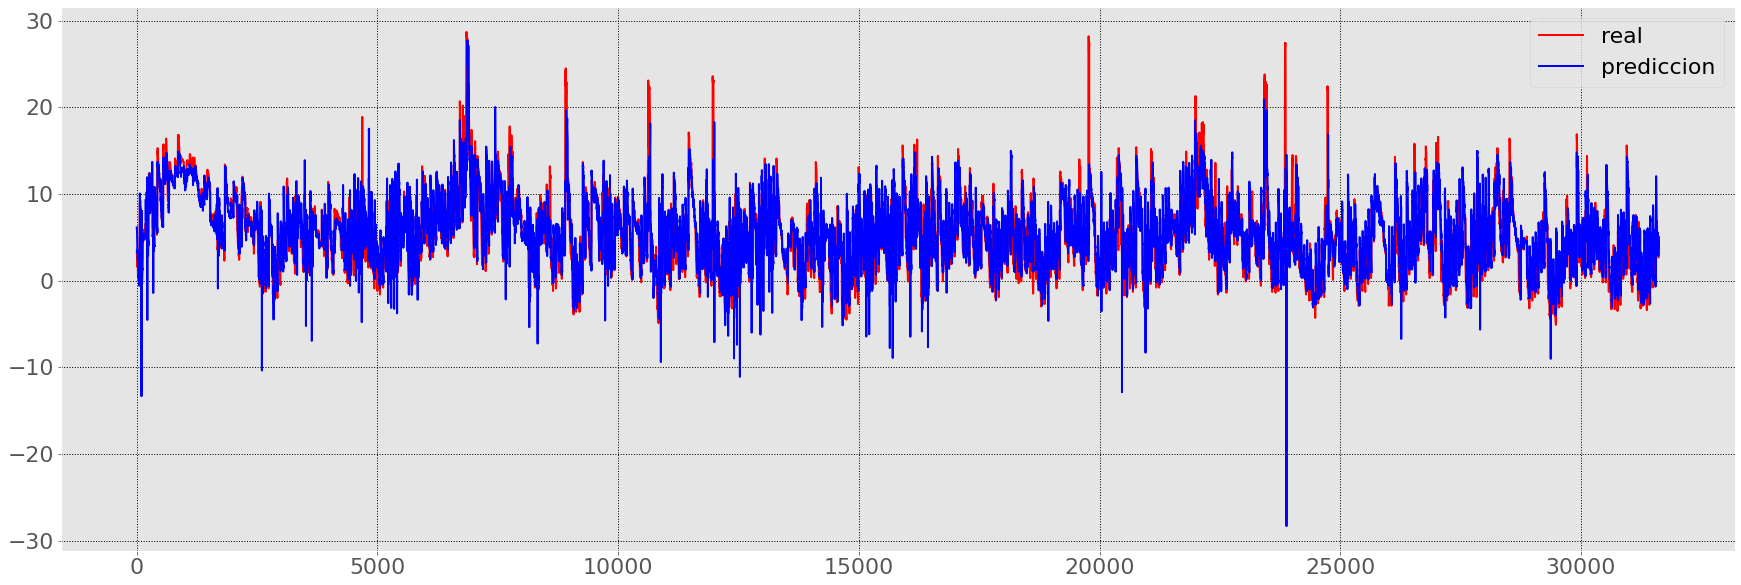

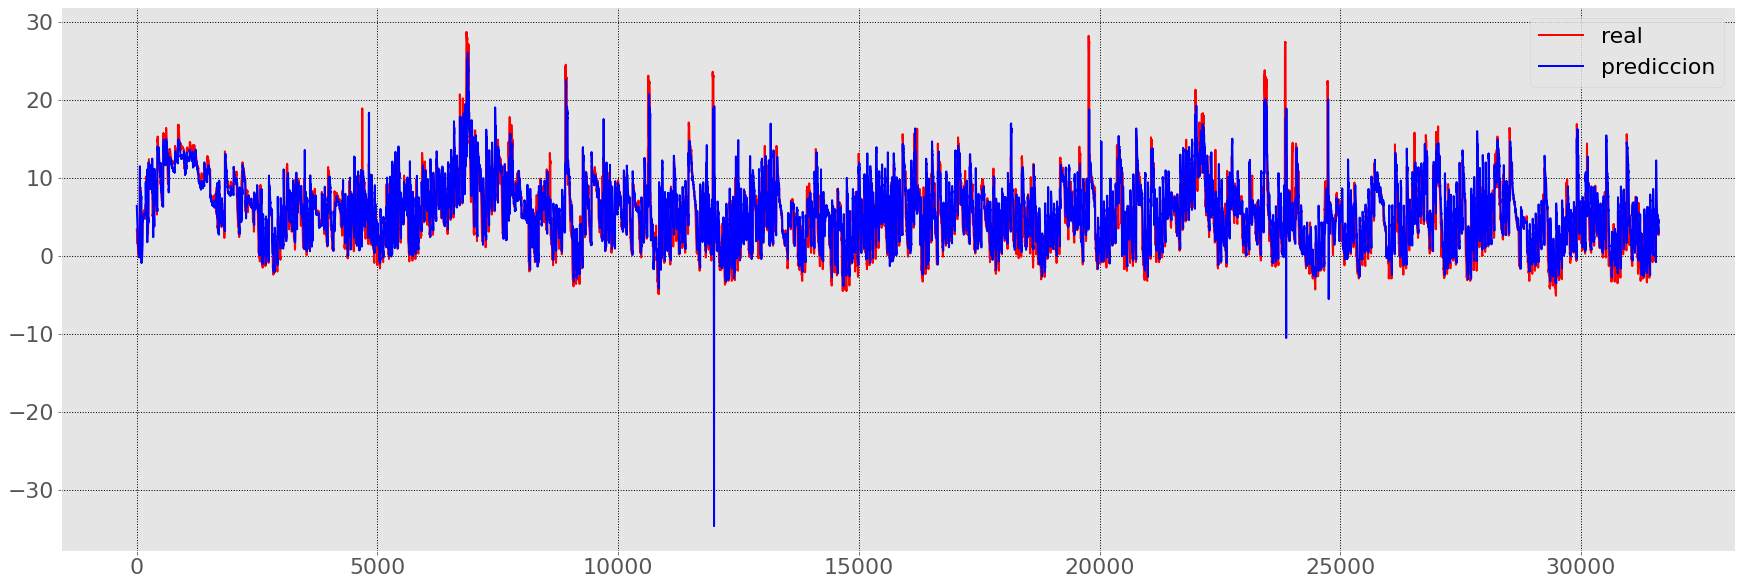

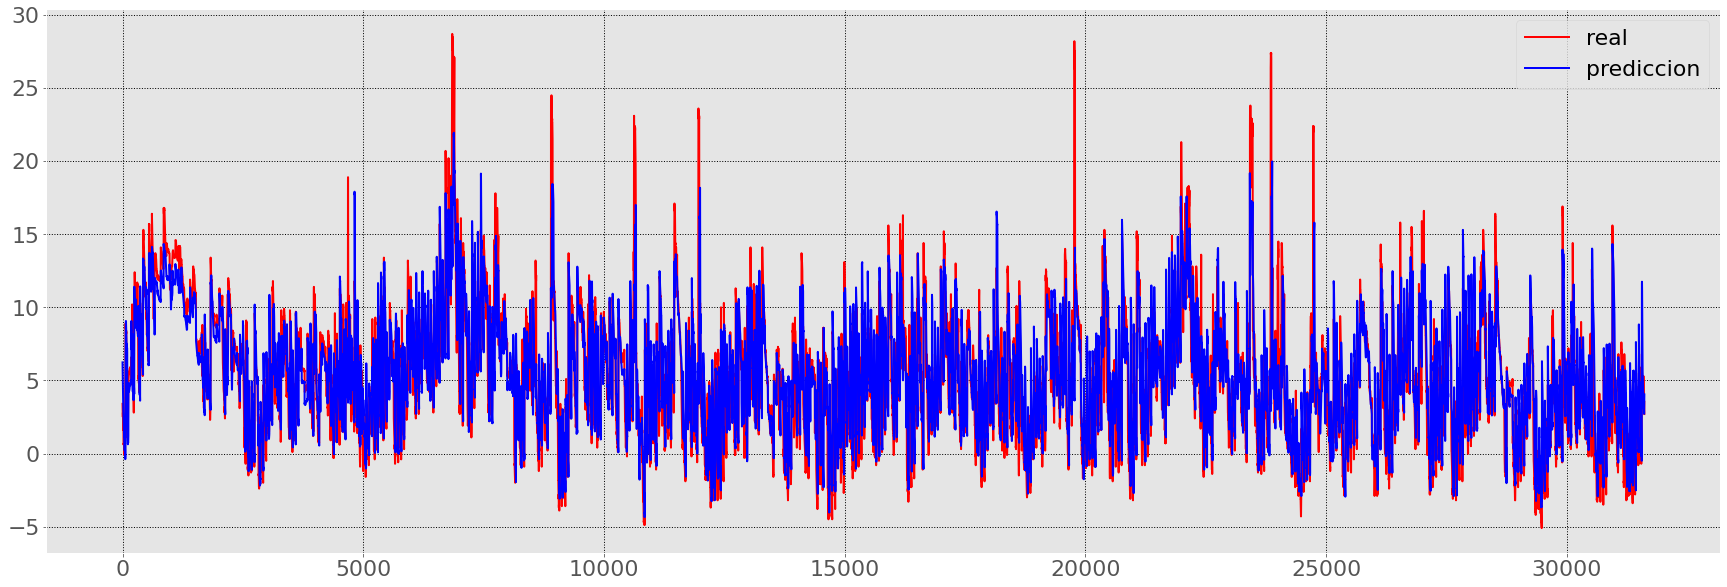

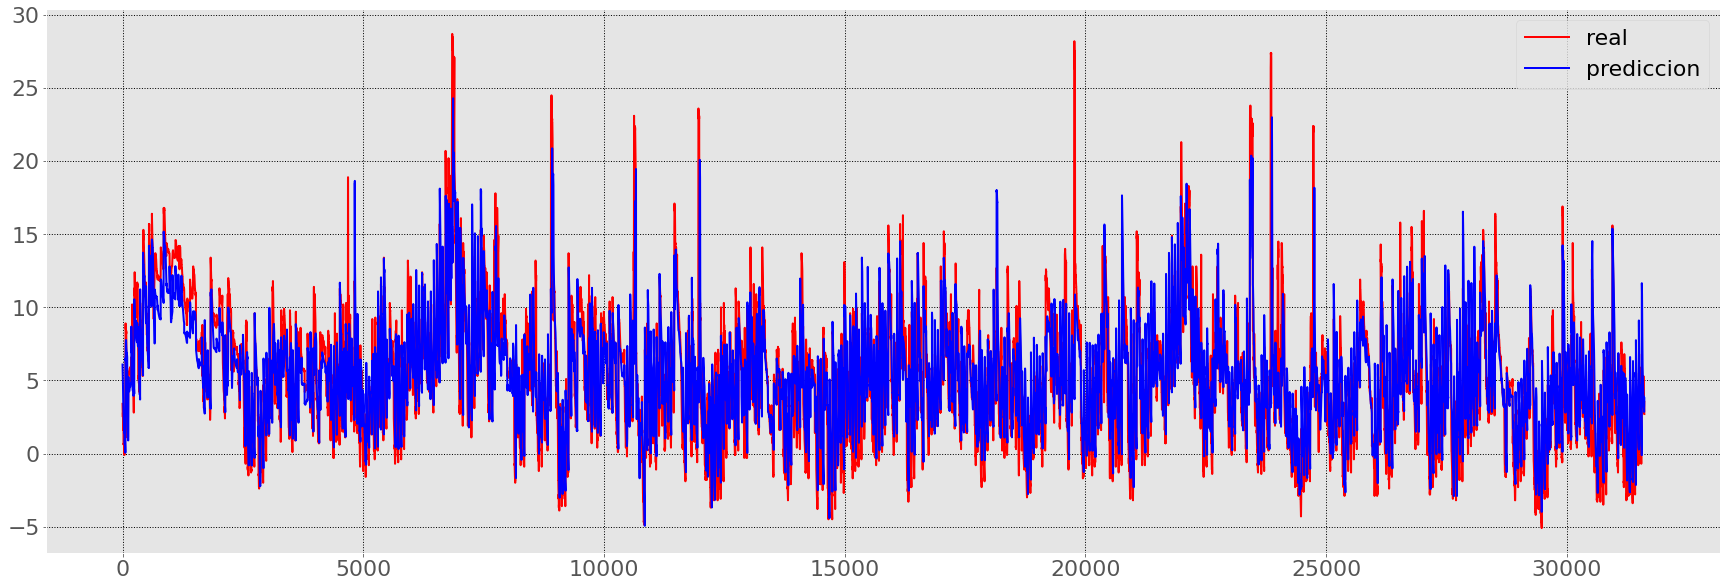

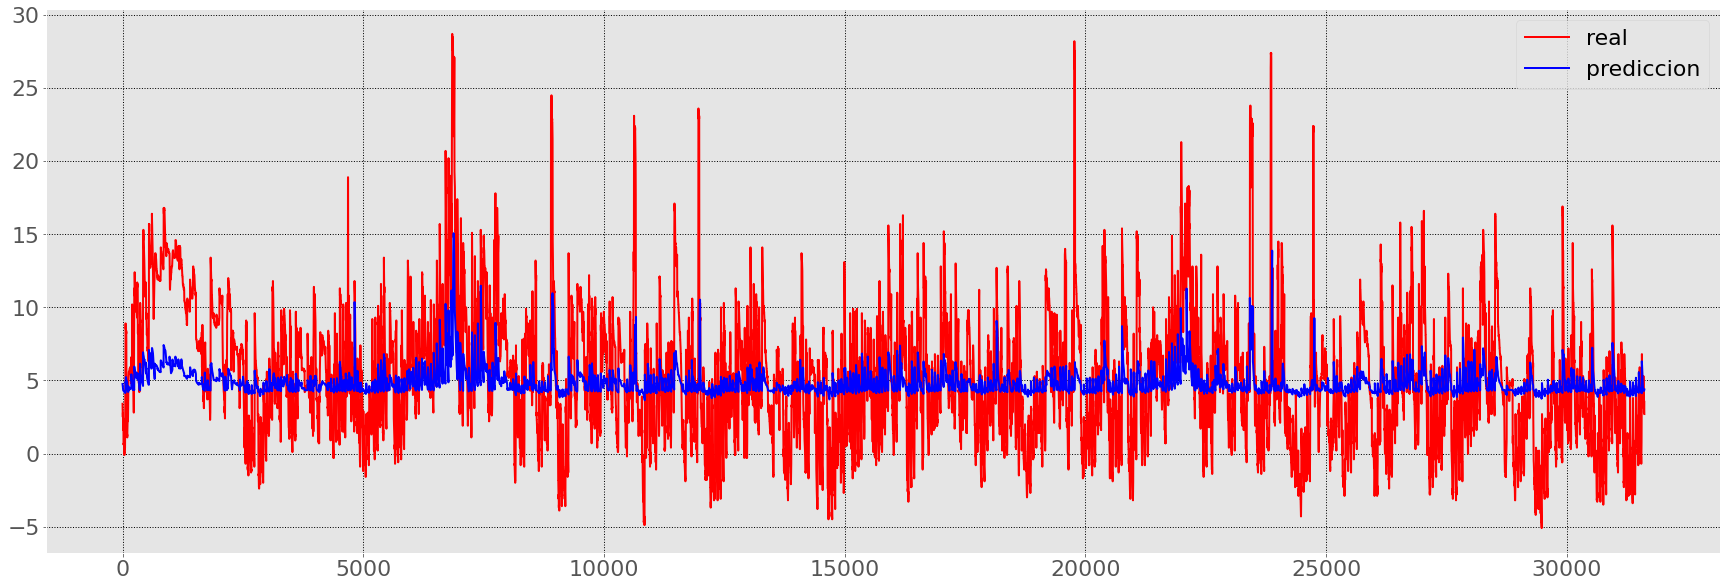

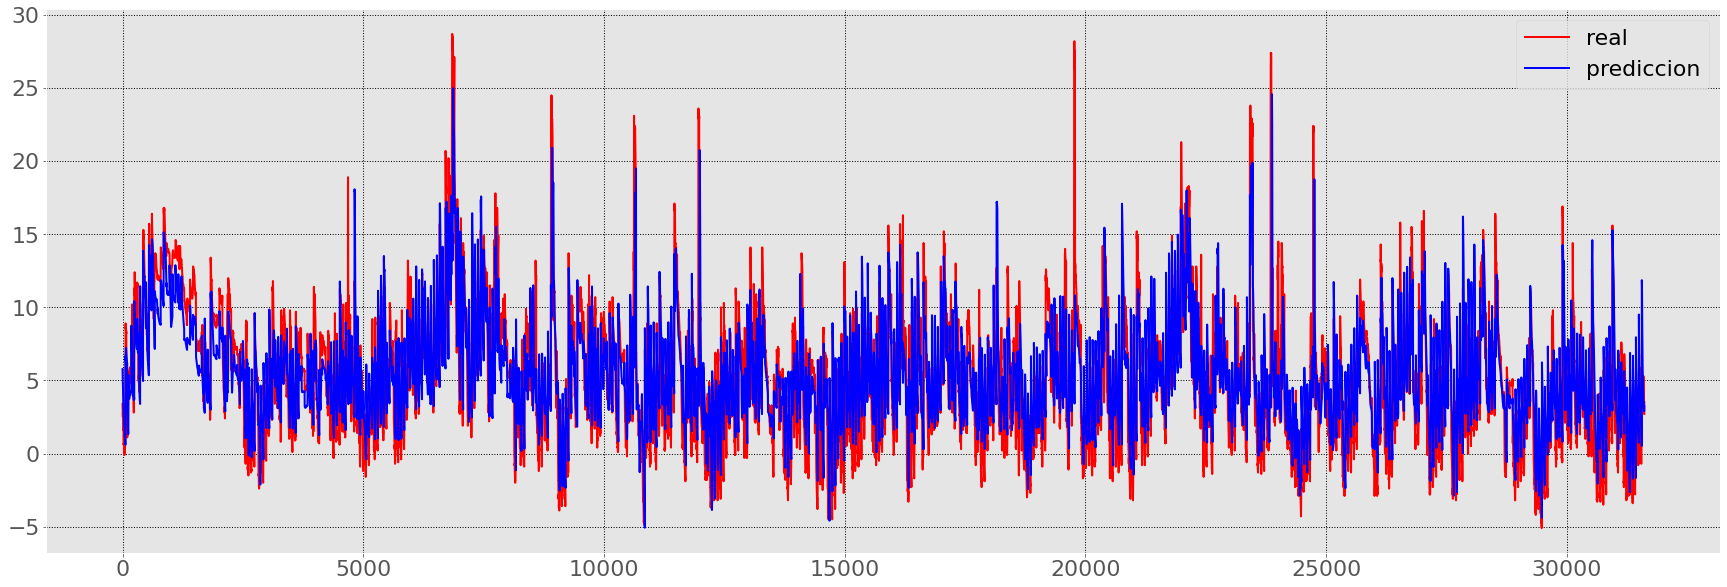

In [ ]:
for i in range(cantidad_modelos):
  plt.plot(ytest.to_numpy().reshape(1,-1)[0], color= "red", label="real")
  plt.plot(m_testPredict[i][:,0], color= "blue", label="prediccion")
  #plt.plot(error_prediction[i], color='green', label= 'error')
  plt.legend()
  plt.show()

#Helada

In [ ]:
index= ytest <= 0
ty= ytest[index]
for i in range(cantidad_modelos):
  py= m_testPredict[i][index]
  print('MSE: %.4f ' % (mean_squared_error(ty, py, squared= True)))

MSE: 5.8244 
MSE: 5.6476 
MSE: 5.6748 
MSE: 6.8685 
MSE: 31.5752 
MSE: 8.7118 


In [ ]:
f_es_helada = lambda x : 0 if (x <= 0) else 1
i= 0
for i in range(len(models)):  
  binario_real = list(map(f_es_helada, ytest))
  binario_pred = list(map(f_es_helada, m_testPredict[i]))
  print("tasa:{:8} precision{:7.3f}".format(learning_rates[i],accuracy_score(binario_real, binario_pred)) )
  print(confusion_matrix(binario_real, binario_pred))
  print(classification_report(binario_real, binario_pred)) 
  i+=1

tasa:   0.001 precision  0.912
[[ 1525  2235]
 [  538 27315]]
              precision    recall  f1-score   support

           0       0.74      0.41      0.52      3760
           1       0.92      0.98      0.95     27853

    accuracy                           0.91     31613
   macro avg       0.83      0.69      0.74     31613
weighted avg       0.90      0.91      0.90     31613

tasa:  0.0001 precision  0.913
[[ 1517  2243]
 [  502 27351]]
              precision    recall  f1-score   support

           0       0.75      0.40      0.53      3760
           1       0.92      0.98      0.95     27853

    accuracy                           0.91     31613
   macro avg       0.84      0.69      0.74     31613
weighted avg       0.90      0.91      0.90     31613

tasa:   1e-05 precision  0.914
[[ 1541  2219]
 [  500 27353]]
              precision    recall  f1-score   support

           0       0.76      0.41      0.53      3760
           1       0.92      0.98      0.95     278

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
f_es_helada = lambda x : 0 if (x <= 0) else 1
i= 0
for i in range(len(models)):  
  binario_real = list(map(f_es_helada, ytest))
  binario_pred = list(map(f_es_helada, m_testPredict[i]))
  print("tasa:{:8} precision{:7.3f}".format(learning_rates[i],accuracy_score(binario_real, binario_pred)) )
  print(confusion_matrix(binario_real, binario_pred))
  print(classification_report(binario_real, binario_pred)) 
  i+=1

tasa:   0.001 precision  0.912
[[ 1525  2235]
 [  538 27315]]
              precision    recall  f1-score   support

           0       0.74      0.41      0.52      3760
           1       0.92      0.98      0.95     27853

    accuracy                           0.91     31613
   macro avg       0.83      0.69      0.74     31613
weighted avg       0.90      0.91      0.90     31613

tasa:  0.0001 precision  0.913
[[ 1517  2243]
 [  502 27351]]
              precision    recall  f1-score   support

           0       0.75      0.40      0.53      3760
           1       0.92      0.98      0.95     27853

    accuracy                           0.91     31613
   macro avg       0.84      0.69      0.74     31613
weighted avg       0.90      0.91      0.90     31613

tasa:   1e-05 precision  0.914
[[ 1541  2219]
 [  500 27353]]
              precision    recall  f1-score   support

           0       0.76      0.41      0.53      3760
           1       0.92      0.98      0.95     278

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.77      0.20      0.32      3760
           1       0.90      0.99      0.94     27853

    accuracy                           0.90     31613
   macro avg       0.84      0.60      0.63     31613
weighted avg       0.89      0.90      0.87     31613

